### 1. Import Dependencies

In [17]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### 2. Import Data

In [25]:
dir_fold_0 = "data/C-NMC_Leukemia/training_data/fold_0"
dir_fold_1 = "data/C-NMC_Leukemia/training_data/fold_1"
dir_fold_2 = "data/C-NMC_Leukemia/training_data/fold_2"

Found 3527 images belonging to 2 classes.
Found 3581 images belonging to 2 classes.
Found 3553 images belonging to 2 classes.


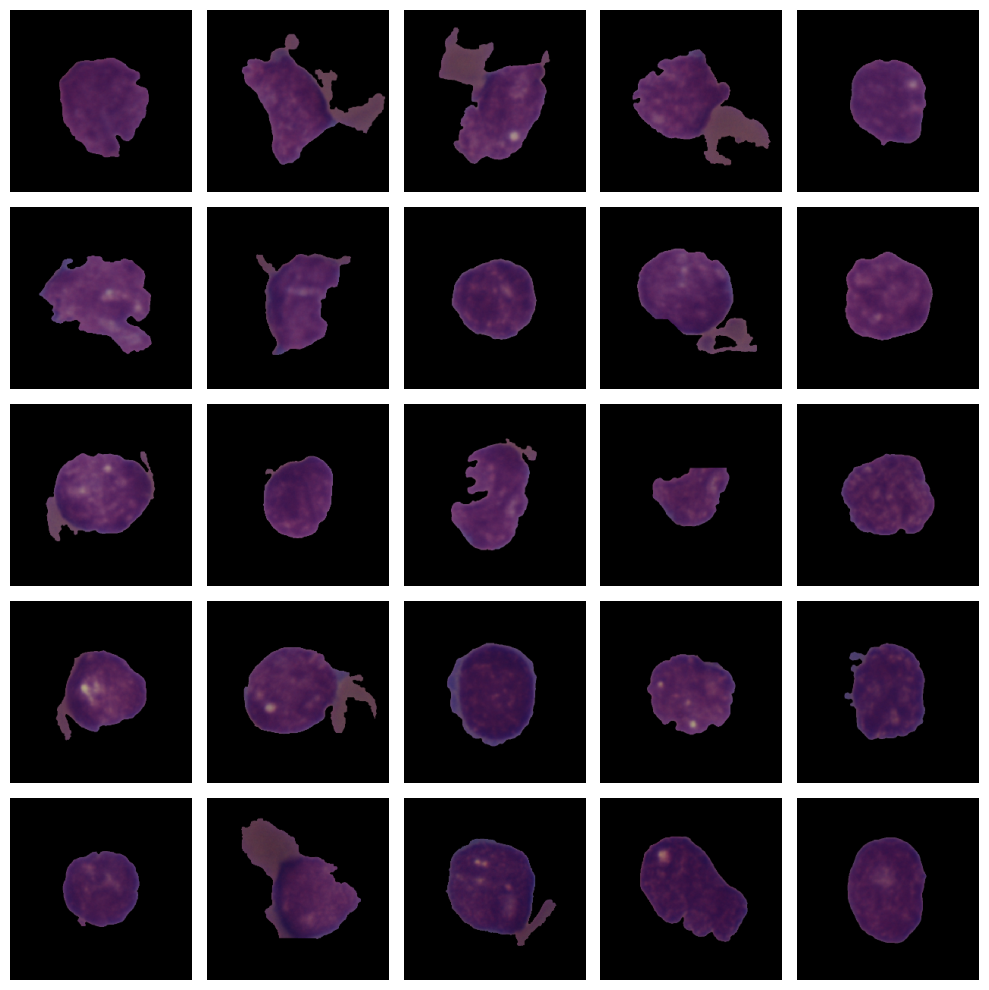

In [71]:
image_size = (240, 240)
batch_size = 32

augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # degrees of random rotations
    width_shift_range=0.1,  # fraction of total width for horizontal shifts
    height_shift_range=0.1,  # fraction of total height for vertical shifts
    shear_range=0.1,  # shearing intensity
    zoom_range=0.1,  # amount of zoom
    horizontal_flip=True,  # randomly flip images horizontally
    fill_mode='nearest'  # strategy to fill newly created pixels
)

datagen = ImageDataGenerator(rescale=1./255)

generator = lambda path: datagen.flow_from_directory(
    path,  # replace with the path to your images
    target_size=image_size,
    batch_size=batch_size,
    #color_mode='grayscale',  # this will load images in grayscale
    class_mode='input',  # if you're not training, this can be set to 'input'
    shuffle=False  # set to False to maintain order
)

# Fetch a batch of images
fold_0 = next(generator(dir_fold_0))
fold_1 = next(generator(dir_fold_1))
fold_2 = next(generator(dir_fold_2))

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.flatten()
for i in range(25):
    ax = axes[i]
    img = fold_0[0][i].squeeze()
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [73]:
len(fold_0)

2

### 3. Build and Compile Model

In [38]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [40]:
model = Sequential()
model.add(Dense(units=32, activation="relu", input_shape=(240, 240, 3)))
model.add(Dense(units=64, activation="relu"))
model.add(Dense(units=1, activation="sigmoid"))

In [41]:
model.compile(loss="binary_crossentropy", optimizer="sgd", metrics="accuracy")

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x 

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [5]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

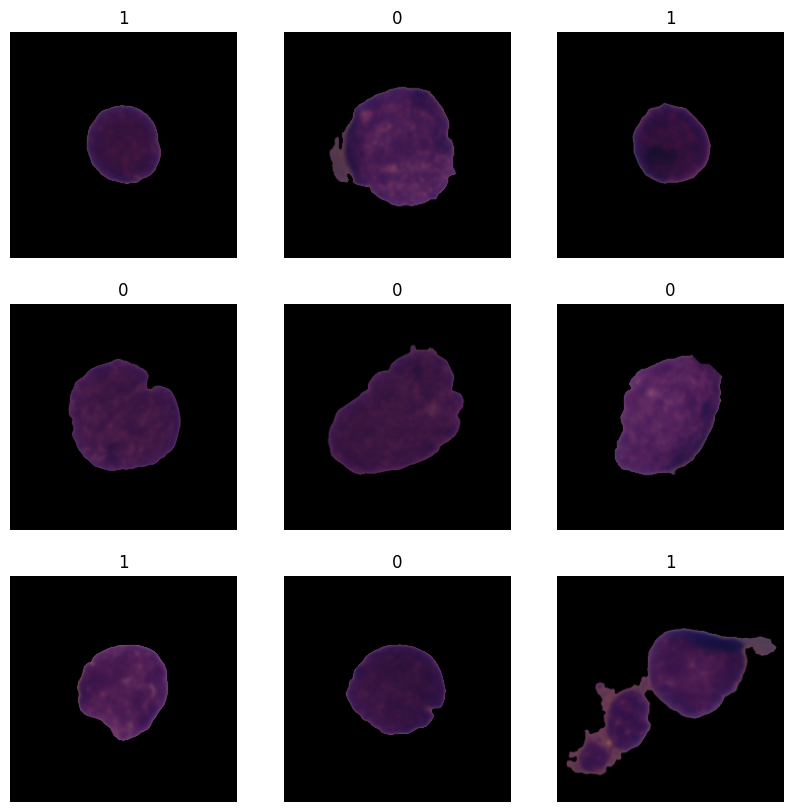

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
        

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

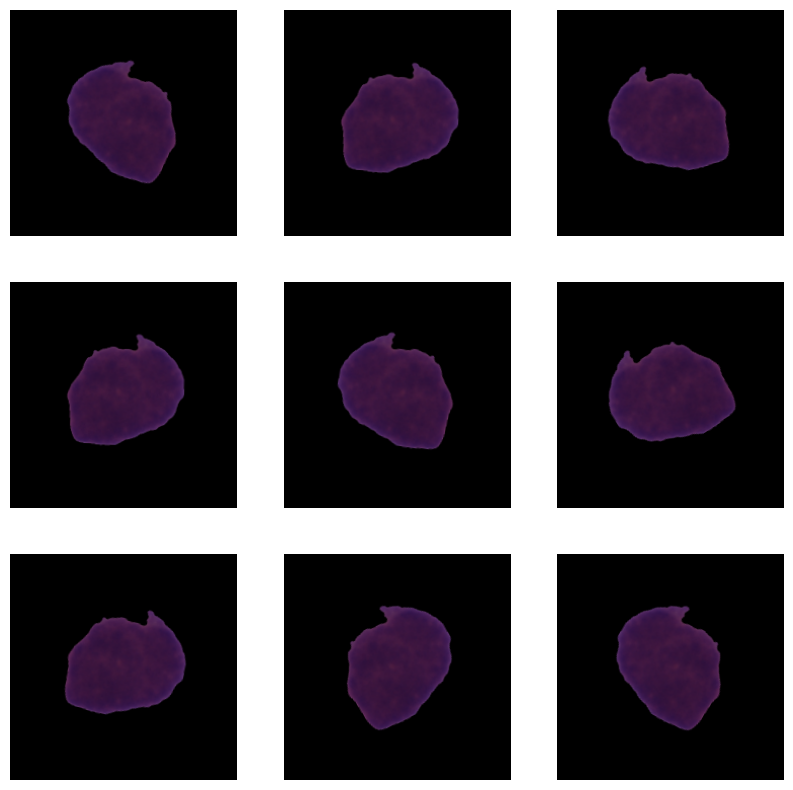

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [9]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x 

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.legacy.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


In [4]:
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)

        for fold_ in filelist:
            foldpath_ = os.path.join(foldpath, fold_)
            filelist_ = os.listdir(foldpath_)

            for file_ in filelist_:
                fpath = os.path.join(foldpath_, file_)
                filepaths.append(fpath)
                labels.append(fold_)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


# Function that create dataframe for train, validation, and test data
def create_df(data_dir):

    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    
    strat = df['labels']
    train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123, stratify=strat)

    # test dataframe   
    strat = dummy_df['labels']
    valid_df, test_df= train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

    return train_df, valid_df, test_df

In [10]:
def get_data(folder_path):
    """
    input: folder path (expects all and hem folders)
    output: data frame [label, image]
    """
    
    hem_path = folder_path + "/hem"
    all_path = folder_path + "/all"

    hem_file_names = [f for f in os.listdir(hem_path) if os.path.isfile(os.path.join(hem_path, f))]
    all_file_names = [f for f in os.listdir(all_path) if os.path.isfile(os.path.join(all_path, f))]

    



In [ ]:
def show_image(image):

    plt.figure(figsize= (20, 20))
    

In [11]:
path = "data/C-NMC_Leukemia/training_data/fold_0"

get_data(path)

['UID_20_1_1_all.bmp', 'UID_4_4_2_all.bmp', 'UID_45_30_2_all.bmp', 'UID_28_2_3_all.bmp', 'UID_35_8_7_all.bmp', 'UID_45_25_8_all.bmp', 'UID_52_15_8_all.bmp', 'UID_22_10_5_all.bmp', 'UID_4_35_3_all.bmp', 'UID_28_15_2_all.bmp', 'UID_35_3_10_all.bmp', 'UID_35_12_7_all.bmp', 'UID_52_17_13_all.bmp', 'UID_22_35_3_all.bmp', 'UID_11_36_2_all.bmp', 'UID_52_17_6_all.bmp', 'UID_52_33_10_all.bmp', 'UID_50_12_6_all.bmp', 'UID_45_27_6_all.bmp', 'UID_50_20_4_all.bmp', 'UID_45_15_4_all.bmp', 'UID_52_20_13_all.bmp', 'UID_52_25_4_all.bmp', 'UID_45_33_10_all.bmp', 'UID_4_8_1_all.bmp', 'UID_52_5_3_all.bmp', 'UID_35_4_4_all.bmp', 'UID_48_35_5_all.bmp', 'UID_14_16_4_all.bmp', 'UID_26_6_9_all.bmp', 'UID_50_1_1_all.bmp', 'UID_17_30_2_all.bmp', 'UID_5_28_4_all.bmp', 'UID_26_36_3_all.bmp', 'UID_48_10_3_all.bmp', 'UID_48_4_3_all.bmp', 'UID_52_29_7_all.bmp', 'UID_43_1_2_all.bmp', 'UID_26_4_7_all.bmp', 'UID_48_22_1_all.bmp', 'UID_48_36_1_all.bmp', 'UID_50_2_5_all.bmp', 'UID_48_11_9_all.bmp', 'UID_35_14_16_all.bmp',